# Update Custom Metrics via GraphQL

## Step 1: Initialize the GraphQL Client using your developer API Key

In [ ]:
!pip install -q gql[all]
from gql import Client, gql
from gql.transport.requests import RequestsHTTPTransport

### Get your API key
First, make sure you have developer permissions. If you are able to visit the [API explorer](https://app.arize.com/graphql), then you have developer permissions. If not, please ask your Account Admin to provide you with access. 

The API key can be retrieved from the [API explorer](https://app.arize.com/graphql) page. Click the button on the top right called "Get Your API Key." A modal will pop up with your key, copy that into the `API_KEY` constant below. 

NOTE: this key is different than the SDK key used to send data to Arize.

In [ ]:
# Initialize GraphQL clients with your GraphQL specific API_KEY - retrieve this in API Explorer
API_KEY = "API_KEY" # TODO: set your API_KEY
 
# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url="https://app.arize.com/graphql/", headers={"x-api-key": API_KEY})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

## Step 2: Retrieve all custom metrics from a model

We will retrieve all custom metrics currently implemented for a model, and return it in a dataframe.

In [ ]:
# We start this query from your model. Models have globally unique IDs. You can get your modelId by visiting app.arize.com. 
# The url will be in this format: https://app.arize.com/organizations/:orgId/spaces/:spaceId/models/:modelId

MODEL_ID = "YOUR_MODEL_ID" # TODO: set the model ID you'd like to retrieve custom metrics for

Define the function used to retrieve all custom metrics for the model with MODEL_ID, and returns it in a dataframe:

In [ ]:
import pandas as pd

# Reusable function for retrieving custom metrics from a model
def get_model_custom_metrics(modelId):
  """Retrieves all custom metrics from a model via its model ID and return in a dataframe."""

  get_custom_metrics_query = gql("""
    query getCustomMetrics($modelId: ID!, $cursor: String) {
      model: node(id: $modelId) {
        ... on Model {
          customMetrics (first: 50, after: $cursor) {
            pageInfo {
              endCursor 
            }
            edges {
              node {
                id
                name
                metric
                description
              }
            }
          }
        }
      }
    }
  """)

  params = {"modelId": modelId}
  custom_metrics_df = None

  while True:
    paged_response = client.execute(get_custom_metrics_query, params)

    custom_metrics_df_page = pd.json_normalize(paged_response["model"]["customMetrics"]["edges"])
    custom_metrics_df_page.columns = custom_metrics_df_page.columns.str.removeprefix("node.")
    custom_metrics_df_page.rename(columns={'id':'customMetricId', 'metric':'customMetric'}, inplace=True)

    if custom_metrics_df is None:
      custom_metrics_df = custom_metrics_df_page
    else:
      custom_metrics_df = pd.concat([custom_metrics_df, custom_metrics_df_page], ignore_index=True)
    
    end_cursor = paged_response["model"]["customMetrics"]["pageInfo"]["endCursor"]
    if end_cursor:
      params["cursor"] = end_cursor
    else:
      break

  return custom_metrics_df

Execute query to get custom metrics for model:

In [ ]:
model_custom_metrics_df = get_model_custom_metrics(MODEL_ID)
model_custom_metrics_df.head()

## Step 3. Update custom metrics

### Step 3a. Edit retrieved custom metrics in Google Sheets

For the purpose of this Colab, we will edit our custom metrics in a Google Sheet for visualization purposes. The custom metrics defined in sheets will then be reimported and applied using GraphQL.

**Note:** The usage of a spreadsheet for editing as an intermediate step is NOT required for updating custom metrics via GraphQL. This is solely for ease of editing and visual representation in this demo.

In [ ]:
# authorize to Google Sheets
!pip install -q gspread
# src: https://colab.research.google.com/notebooks/snippets/sheets.ipynb
from google.colab import auth
auth.authenticate_user()

import gspread
from gspread_dataframe import set_with_dataframe
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

Upon running the cell below, the sheet will be pre-populated with all custom metrics retrieved (the image shows an example of what you may see).

Go ahead and make any modifications to these custom metrics right in the sheet but **IMPORTANT: Do NOT edit the customMetricId column!**

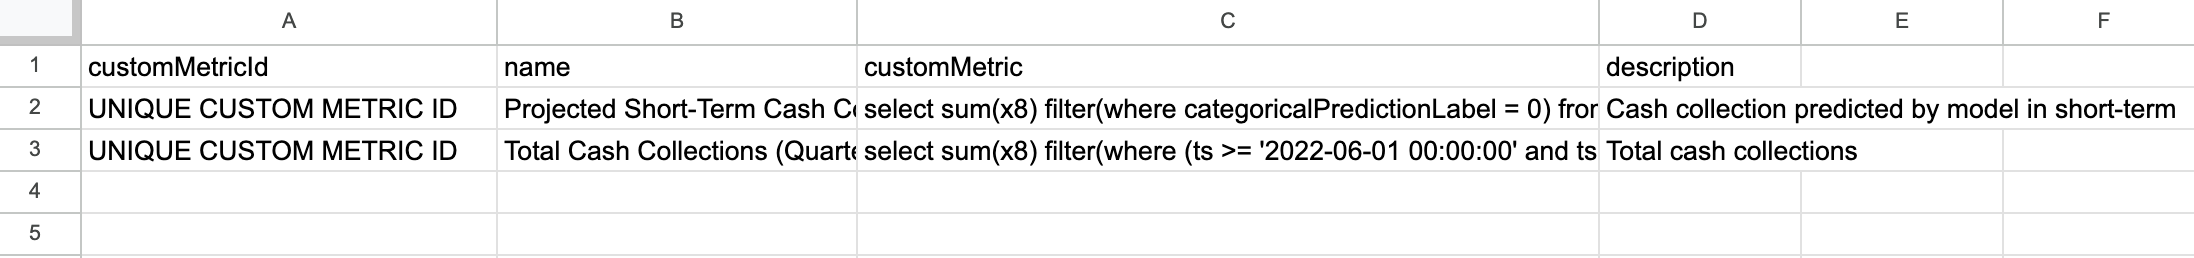

In [ ]:
from datetime import datetime

# create sheet and populate it with custom metrics
sheet_name = f"Custom Metrics Worksheet"
sh = gc.create(sheet_name)

currentTime = datetime.now().strftime("%H:%M:%S")
worksheet_name = f"Custom Metrics from Model ID {MODEL_ID} | {currentTime}"
worksheet = gc.open(sheet_name).sheet1
worksheet.update_title(worksheet_name)

set_with_dataframe(worksheet=worksheet, dataframe=model_custom_metrics_df, include_index=False, include_column_header=True)

print(f"Edit custom metrics in Google Sheet: {sh.url}")

### Step 3b. Import data from Sheets, and issue GraphQL mutation to update these Custom Metrics

In [ ]:
# ingest entries from Google Sheets back into a pandas dataframe to be parsed for GraphQL payloads
worksheet = sh.worksheet(worksheet_name)

custom_metric_updates_df = pd.DataFrame(worksheet.get_all_records())
custom_metric_updates_df.head()

In [ ]:
# define update mutation
update_custom_metrics_for_model_mutation = gql(
"""
    mutation updateCustomMetricMutation(
      $customMetricId: ID!,
      $modelId: ID!,
      $name: String!,
      $description: String!,
      $customMetric: String!
    ) {
      updateCustomMetric(
        input: {
          customMetricId: $customMetricId,
          modelId: $modelId,
          name: $name,
          description: $description,
          customMetric: $customMetric
        }
      ) {
        customMetric { id, name, createdAt, metric }
      }
    }
""")

In [ ]:
import time
from pprint import pprint

def create_custom_metrics(custom_metrics_updates_df, original_custom_metrics_df):
  CUSTOM_METRIC_ID_COL_NAME = "customMetricId"

  # 1. We ensure that no custom metric *IDs* were modified or added
  # NOTE: If you would like to create NEW custom metrics, please refer to the Create_Custom_Metrics_Use_Case.ipynb example.
  original_ids = original_custom_metrics_df[CUSTOM_METRIC_ID_COL_NAME]
  updated_sheet_ids = custom_metrics_updates_df[CUSTOM_METRIC_ID_COL_NAME]

  if len(original_ids) != len(updated_sheet_ids) or \
    set(original_ids) != set(updated_sheet_ids):
    print(f'❌ Please do not add or remove rows from the original spreadsheet. Rerun from step 3a - edit only non customMetricId fields.')
    return

  # 2. Update custom metrics
  for i, update_row in custom_metrics_updates_df.iterrows():
    original_row = original_custom_metrics_df.loc[original_custom_metrics_df[CUSTOM_METRIC_ID_COL_NAME] == update_row[CUSTOM_METRIC_ID_COL_NAME]].squeeze()

    for field_name, original_val in original_row.items():
      # Send mutation request for only custom metric where fields have been updated
      if str(update_row[field_name]) != str(original_val):
        print(f"Detected change for custom metric with ID: {update_row[CUSTOM_METRIC_ID_COL_NAME]}")
        update_custom_metric_args = update_row.to_dict()
        update_custom_metric_args["modelId"] = MODEL_ID
        
        res = client.execute(update_custom_metrics_for_model_mutation, update_custom_metric_args, serialize_variables=True)

        print(f"Custom metric updated:")
        pprint(res["updateCustomMetric"]["customMetric"])
        print("\n")

        time.sleep(0.1) # give a bit of breathing room between updates
        break

In [ ]:
create_custom_metrics(custom_metric_updates_df, model_custom_metrics_df)